# Calibration Vega at LSST


- Author : Sylvie Dagoret-Campagne
- afflilation : IJCLab
- Last verification : December 14th 2021


Purpose : check how pysynphot works : How the number of photoelectrons (photons) are calculated and magnitudes as well if Vega were to be seen through LSST.

First redo what is done in **MyVegaCalib.ipynb** and then apply LSST filters and atmosphere to get the number of photoelectrons



In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline

In [3]:
import pysynphot as S

In [4]:
from astropy import units as u

# To force the detector surface to be the LSST one
https://pysynphot.readthedocs.io/en/latest/ref_api.html#pysynphot.refs.setref

Key numbers:

https://www.lsst.org/scientists/keynumbers

In [5]:
 S.refs.showref()

graphtable: /Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/mtab/57g1733im_tmg.fits
 comptable: /Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/mtab/5as18041m_tmc.fits
thermtable: /Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/mtab/3241637sm_tmt.fits
      area: 45238.93416
   waveset: Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True


In [6]:
# LSST
NBBANDS=6
band_to_number={'u':0,'g':1,'r':2,'i':3,'z':4,'y4':5}
band_to_number_2={'u':0,'g':1,'r':2,'i':3,'z':4,'y':5}
number_to_band={0:'u',1:'g',2:'r',3:'i',4:'z',5:'y4'}
number_to_band_2={0:'u',1:'g',2:'r',3:'i',4:'z',5:'y'}
filtercolor=['blue','green','red','orange','grey','black']
NBCOLORS=NBBANDS-1
number_to_color={0:'U-G',1:'G-R',2:'R-I',3:'I-Z',4:'Z-Y'}
color_to_number={'U-G':0,'G-R':1,'R-I':2,'I-Z':3,'Z-Y':4}
mpl_colors_col=['b','g','r','y','k']

WLMIN=3000. # Minimum wavelength : PySynPhot works with Angstrom
WLMAX=11000. # Minimum wavelength : PySynPhot works with Angstrom

NBINS=int(WLMAX-WLMIN) # Number of bins between WLMIN and WLMAX
BinWidth=(WLMAX-WLMIN)/float(NBINS) # Bin width in Angstrom
WL=np.linspace(WLMIN,WLMAX,NBINS)   # Array of wavelength in Angstrom

In [7]:
# my old way to get effective surface
LSST_COLL_SURF=35*(u.m)**2/(u.cm)**2  # LSST collectif surface
LSST_COLL_SURF.decompose()

<Quantity 350000.>

In [8]:
# from key numbers
Deff=642.3 # effective radius in cm
Seff= np.pi*Deff**2/4  # in cm2
Seff

324015.4546769212

In [9]:
S.refs.setref(area=Seff, waveset=None) # set by default to 6.4230 m2

In [10]:
#S.refs.setref(area=LSST_COLL_SURF.decompose(), waveset=None)
S.refs.set_default_waveset(minwave=WLMIN, maxwave=WLMAX, num=NBINS, delta=BinWidth, log=False)
S.refs.showref()

EXPOSURE=30.0                      # LSST Exposure time

graphtable: /Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/mtab/57g1733im_tmg.fits
 comptable: /Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/mtab/5as18041m_tmc.fits
thermtable: /Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/mtab/3241637sm_tmt.fits
      area: 324015.4546769212
   waveset: Min: 3000.0, Max: 11000.0, Num: None, Delta: 1.0, Log: False


In [11]:
 S.refs.showref()

graphtable: /Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/mtab/57g1733im_tmg.fits
 comptable: /Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/mtab/5as18041m_tmc.fits
thermtable: /Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/mtab/3241637sm_tmt.fits
      area: 324015.4546769212
   waveset: Min: 3000.0, Max: 11000.0, Num: None, Delta: 1.0, Log: False


In [12]:
pysynphot_root_path=os.environ['PYSYN_CDBS']

In [13]:
plt.rcParams["axes.labelsize"]="large"
plt.rcParams["axes.linewidth"]=2.0
plt.rcParams["xtick.major.size"]=8
plt.rcParams["ytick.major.size"]=8
plt.rcParams["ytick.minor.size"]=5
plt.rcParams["xtick.labelsize"]="large"
plt.rcParams["ytick.labelsize"]="large"

plt.rcParams["figure.figsize"]=(10,6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
#plt.rcParams['axes.facecolor'] = 'blue'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
plt.rcParams['lines.markersize'] = 5  # markersize, in points
plt.rcParams['grid.alpha'] = 0.75 # transparency, between 0.0 and 1.0
plt.rcParams['grid.linestyle'] = '-' # simple line
plt.rcParams['grid.linewidth'] = 0.4 # in points
plt.rcParams['font.size'] = 13

In [14]:
XMIN=3000.
XMAX=11000.

# Set the primary mirror surface by default

# Constants

$$
    m_{AB} = -2.5 \times \log_{10} \left( \frac{f_\nu}{3631 Jy} \right) 
$$

$$
   1 Jy = 10^{−26} W . Hz^{−1} . m^{−2} = 10^{−23} erg . s^{−1} . Hz^{−1} . cm^{−2} 
$$

$$
     m_{AB} = -2.5 \times \log_{10} \left( \frac{f_\nu}{1 Jy} \right) + 8.5
$$

$$
     m_{AB} = -2.5 \times \log_{10} ( f_\nu ) - 48.6
$$

When $f_\nu$ is expressed in  $erg.s^{−1}.cm^{−2} . Hz^{−1}$

In [15]:
S.units.ABZERO

-48.6

In [16]:
S.units.STZERO

-21.1

In [17]:
# Angstrom per second
S.units.C

2.99792458e+18

In [18]:
# erg.s
S.units.H

6.6262e-27

# SED in flam Units:

  $$ 
  erg/s/cm^2/A 
  $$

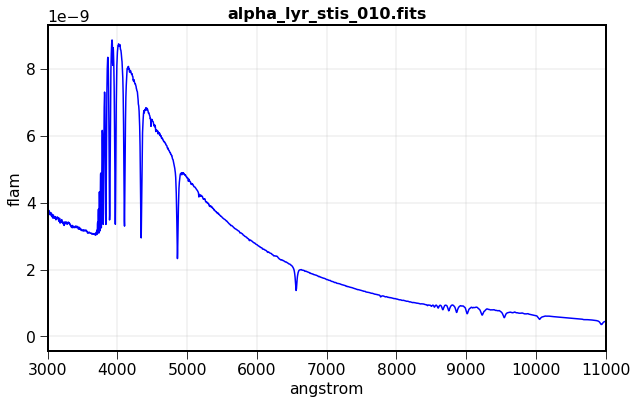

In [19]:
spec_vega=S.Vega
#spec_vega.convert("nm")

plt.plot(spec_vega.wave, spec_vega.flux,"b-")
plt.xlabel(spec_vega.waveunits)
plt.ylabel(spec_vega.fluxunits)
plt.title(os.path.basename(spec_vega.name))
plt.xlim(XMIN,XMAX)
plt.grid()

# SED in Vega Units:

$$
 M= −2.5 \times \log(flux/flux_{Vega})
$$

In [20]:
spec_vega.convert("vegamag")

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pysynphot/units.py:913: RuntimeWarning: invalid value encountered in true_divide
  normalized = flux / resampled._fluxtable


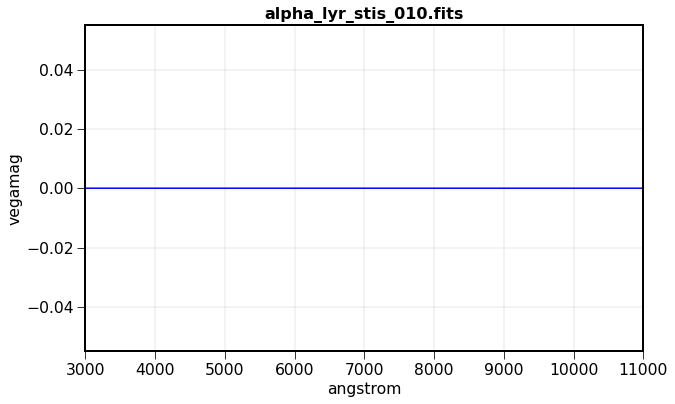

In [21]:
plt.plot(spec_vega.wave, spec_vega.flux,"b-")
plt.xlabel(spec_vega.waveunits)
plt.ylabel(spec_vega.fluxunits)
plt.title(os.path.basename(spec_vega.name))
plt.xlim(XMIN,XMAX)
plt.grid()

# SED in photlam Units:

  $$ 
  photons/s/cm^2/A
  $$

In [22]:
spec_vega.convert("photlam")

flat_nu = S.FlatSpectrum(0, fluxunits='abmag')
flat_lambda=S.FlatSpectrum(0, fluxunits='stmag')

flat_nu.convert("photlam")
flat_lambda.convert("photlam")

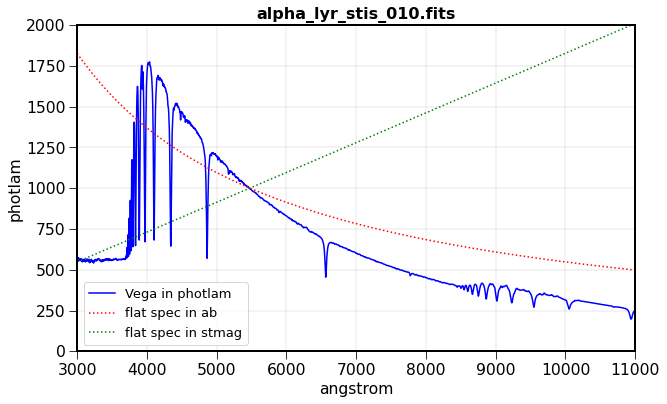

In [23]:

plt.plot(spec_vega.wave, spec_vega.flux,"b-",label="Vega in photlam")
plt.xlabel(spec_vega.waveunits)
plt.ylabel(spec_vega.fluxunits)
plt.title(os.path.basename(spec_vega.name))
plt.xlim(XMIN,XMAX)
plt.ylim(0,2000)
plt.grid()

plt.plot(flat_nu.wave,flat_nu.flux,"r:",label="flat spec in ab")
plt.plot(flat_lambda.wave,flat_lambda.flux,"g:",label="flat spec in stmag")

plt.legend()

# Observation in standard Johnson filters witout atmosphere

https://pysynphot.readthedocs.io/en/latest/units.html

In [24]:
bp_v = S.ObsBandpass('johnson,v')
bp_u = S.ObsBandpass('johnson,u')
bp_b = S.ObsBandpass('johnson,b')
bp_r = S.ObsBandpass('johnson,r')
bp_i = S.ObsBandpass('johnson,i')

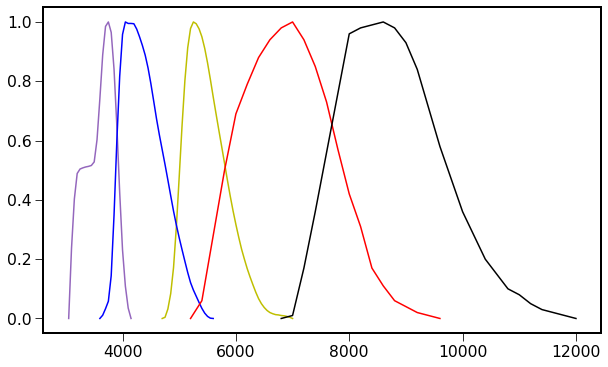

In [25]:
plt.plot(bp_v.wave,bp_v.throughput,"y-")
plt.plot(bp_u.wave,bp_u.throughput,"-",color="tab:purple")
plt.plot(bp_b.wave,bp_b.throughput,"b-")
plt.plot(bp_r.wave,bp_r.throughput,"r-")
plt.plot(bp_i.wave,bp_i.throughput,"k-")

In [26]:
obs_v = S.Observation(spec_vega, bp_v)
obs_u = S.Observation(spec_vega, bp_u)
obs_b = S.Observation(spec_vega, bp_b)
obs_r = S.Observation(spec_vega, bp_r)
obs_i = S.Observation(spec_vega, bp_i)

(/Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/comp/nonhst/johnson_v_004_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(/Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/comp/nonhst/johnson_u_004_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(/Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/comp/nonhst/johnson_b_004_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(/Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/comp/nonhst/johnson_r_003_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(/Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/comp/nonhst/johnson_i_003_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


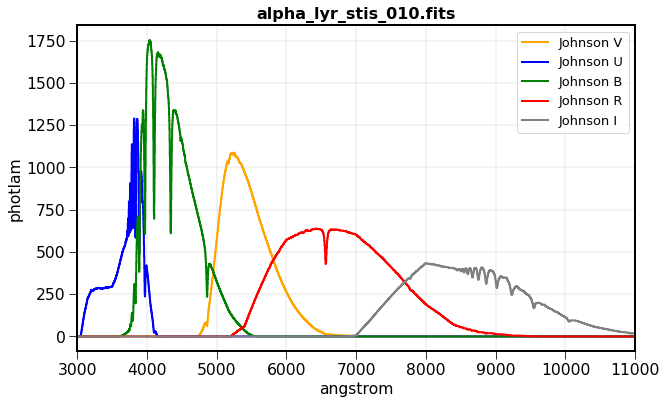

In [27]:
plt.plot(obs_v.binwave, obs_v.binflux, drawstyle='steps-mid',color="orange",lw=2,label="Johnson V")
plt.plot(obs_u.binwave, obs_u.binflux, drawstyle='steps-mid',color="blue",lw=2,label="Johnson U")
plt.plot(obs_b.binwave, obs_b.binflux, drawstyle='steps-mid',color="green",lw=2,label="Johnson B")
plt.plot(obs_r.binwave, obs_r.binflux, drawstyle='steps-mid',color="red",lw=2,label="Johnson R")
plt.plot(obs_i.binwave, obs_i.binflux, drawstyle='steps-mid',color="grey",lw=2,label="Johnson I")
plt.xlabel(obs_v.waveunits)
plt.ylabel(obs_v.fluxunits)
plt.title(os.path.basename(spec_vega.name))
plt.xlim(XMIN,XMAX)
plt.grid()
plt.legend()

In [28]:
print(obs_v.primary_area)

None


In [29]:
obs_v.convert('counts')

In [30]:
obs_v.countrate()

277700094632.74976

In [31]:
obs_b.countrate()

415322724202.5296

In [32]:
obs_u.countrate()

146324841296.6219

# Perfect filters

In [33]:
filt_wlcenter=np.arange(3500,10500,500)

In [34]:
delta_W=10

In [35]:
filt_wlcenter

array([ 3500,  4000,  4500,  5000,  5500,  6000,  6500,  7000,  7500,
        8000,  8500,  9000,  9500, 10000])

In [36]:
NBWL=len(filt_wlcenter)

In [37]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBWL)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBWL), alpha=1)

In [38]:
all_bp=[]
all_obs=[]
for wl in filt_wlcenter:
    thebp= bp = S.Box(wl, delta_W)
    theobs=S.Observation(spec_vega,thebp)
    all_bp.append(thebp)
    all_obs.append(theobs)

(<pysynphot.spectrum.Box object at 0x7f94e1814be0>) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(<pysynphot.spectrum.Box object at 0x7f94e17f49d0>) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(<pysynphot.spectrum.Box object at 0x7f94e15b28b0>) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(<pysynphot.spectrum.Box object at 0x7f94d0133400>) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(<pysynphot.spectrum.Box object at 0x7f94d0133160>) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(<pysynphot.spectrum.Box object at 0x7f94d01339a0>) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(<pysynphot.spectrum.Box object at 0x7f94d0133d00>) does not have a de

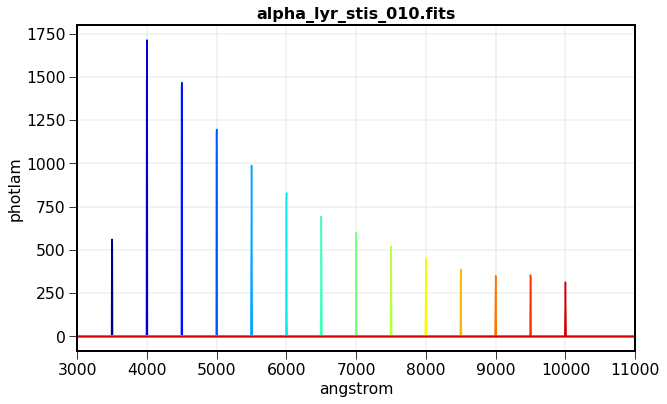

In [39]:
idx=0
for theobs in all_obs:
    plt.plot(theobs.binwave,theobs.binflux,color=all_colors[idx])
    idx+=1
    
plt.xlabel(theobs.waveunits)
plt.ylabel(theobs.fluxunits)
plt.title(os.path.basename(spec_vega.name))
plt.xlim(XMIN,XMAX)
plt.grid()
#plt.legend()

# dedicated measured points

In [40]:
filt_wlcenter=np.array([3600.,4400.,5500.,7100.,9700.])

In [41]:
NBWL=len(filt_wlcenter)

In [42]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBWL)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBWL), alpha=1)

In [43]:
all_bp=[]
all_obs=[]
for wl in filt_wlcenter:
    thebp= bp = S.Box(wl, delta_W)
    theobs=S.Observation(spec_vega,thebp)
    all_bp.append(thebp)
    all_obs.append(theobs)

(<pysynphot.spectrum.Box object at 0x7f94e15b2850>) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(<pysynphot.spectrum.Box object at 0x7f94e17f4b20>) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(<pysynphot.spectrum.Box object at 0x7f94e1814310>) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(<pysynphot.spectrum.Box object at 0x7f952183dca0>) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(<pysynphot.spectrum.Box object at 0x7f952183db80>) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


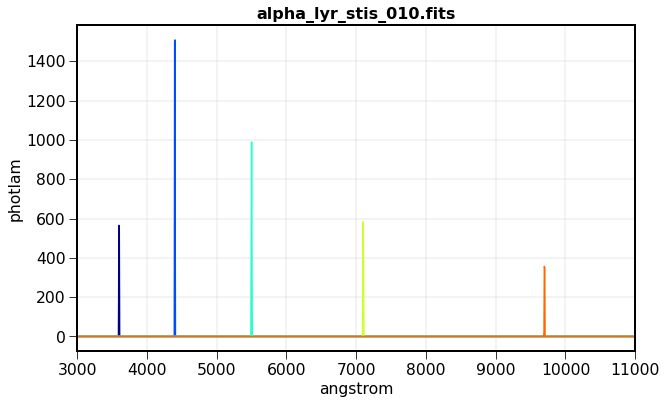

In [44]:
idx=0
for theobs in all_obs:
    plt.plot(theobs.binwave,theobs.binflux,color=all_colors[idx])
    idx+=1
    
plt.xlabel(theobs.waveunits)
plt.ylabel(theobs.fluxunits)
plt.title(os.path.basename(spec_vega.name))
plt.xlim(XMIN,XMAX)
plt.grid()
#plt.legend()

# Results in filter bands

Units are defined in 
https://pysynphot.readthedocs.io/en/latest/units.html#pysynphot-units-counts-mags

## Countrate

In [45]:
idx=0
for theobs in all_obs:
    print("wl=",filt_wlcenter[idx]," A, count-rate=",theobs.countrate()," photons/s")
    print("wl=",filt_wlcenter[idx]," A, \t ==> instrum magnitude=",-2.5*np.log10(theobs.countrate())," obmag")
    idx+=1

wl= 3600.0  A, count-rate= 1826938845.6713476  photons/s
wl= 3600.0  A, 	 ==> instrum magnitude= -23.1543100254257  obmag
wl= 4400.0  A, count-rate= 4873696067.144184  photons/s
wl= 4400.0  A, 	 ==> instrum magnitude= -24.219646105680525  obmag
wl= 5500.0  A, count-rate= 3204380794.646028  photons/s
wl= 5500.0  A, 	 ==> instrum magnitude= -23.76436030035539  obmag
wl= 7100.0  A, count-rate= 1889791368.722304  photons/s
wl= 7100.0  A, 	 ==> instrum magnitude= -23.191034652742687  obmag
wl= 9700.0  A, count-rate= 1153801779.396889  photons/s
wl= 9700.0  A, 	 ==> instrum magnitude= -22.655328010982537  obmag


## OBmag : Instrumental magnitude

the instrumental magnitude that is the logarithmic form of counts
https://pysynphot.readthedocs.io/en/latest/units.html#pysynphot-units-counts-mags

In [46]:
idx=0
for theobs in all_obs:
    print("wl=",filt_wlcenter[idx]," A, magnitude in obmag units = ",theobs.effstim("obmag"),"obmag")
    idx+=1

wl= 3600.0  A, magnitude in obmag units =  -23.1543100254257 obmag
wl= 4400.0  A, magnitude in obmag units =  -24.219646105680525 obmag
wl= 5500.0  A, magnitude in obmag units =  -23.76436030035539 obmag
wl= 7100.0  A, magnitude in obmag units =  -23.191034652742687 obmag
wl= 9700.0  A, magnitude in obmag units =  -22.655328010982537 obmag


## VEGAmag

In [47]:
idx=0
for theobs in all_obs:
    print("wl=",filt_wlcenter[idx]," A, magnitude in vega units = ",theobs.effstim("vegamag"),"vegamag")
    idx+=1

wl= 3600.0  A, magnitude in vega units =  0.0 vegamag
wl= 4400.0  A, magnitude in vega units =  0.0 vegamag
wl= 5500.0  A, magnitude in vega units =  0.0 vegamag
wl= 7100.0  A, magnitude in vega units =  0.0 vegamag
wl= 9700.0  A, magnitude in vega units =  0.0 vegamag


## ABmag

In [48]:
idx=0
for theobs in all_obs:
    print("wl=",filt_wlcenter[idx]," A, magnitude in abmag units = ",theobs.effstim("abmag"),"abmag")
    idx+=1

wl= 3600.0  A, magnitude in abmag units =  1.0781888919027764 abmag
wl= 4400.0  A, magnitude in abmag units =  -0.20502313261414962 abmag
wl= 5500.0  A, magnitude in abmag units =  0.007987225187624958 abmag
wl= 7100.0  A, magnitude in abmag units =  0.3040733826912678 abmag
wl= 9700.0  A, magnitude in abmag units =  0.5009962723150245 abmag


## STmag

In [49]:
idx=0
for theobs in all_obs:
    print("wl=",filt_wlcenter[idx]," A, magnitude in stmag units = ",theobs.effstim("stmag"),"stmag")
    idx+=1

wl= 3600.0  A, magnitude in stmag units =  0.16764592434878622 stmag
wl= 4400.0  A, magnitude in stmag units =  -0.679814442432642 stmag
wl= 5500.0  A, magnitude in stmag units =  0.017746642171113436 stmag
wl= 7100.0  A, magnitude in stmag units =  0.8683116602760208 stmag
wl= 9700.0  A, magnitude in stmag units =  1.7428019708493387 stmag


# Observation of Vega  in LSST

## LSST filters

- Access to LSST throughput:

includes QE and filter passband




In [50]:
df=pd.read_csv("lsst_throughput.csv",index_col=0)

In [51]:
df

,wl,u,g,r,i,z,y
0,300,0.000711,0.000000,0.000000,0.000034,0.000000,0.000000
1,301,0.000440,0.000000,0.000000,0.000155,0.000000,0.000000
2,302,0.000591,0.000000,0.000000,0.000072,0.000000,0.000000
3,303,0.000022,0.000000,0.000000,0.000034,0.000000,0.000000
4,304,0.000229,0.000000,0.000000,0.000034,0.000000,0.000000
...,...,...,...,...,...,...,...
896,1196,0.000029,0.000298,0.000088,0.000121,0.000560,0.016426
897,1197,0.000024,0.000357,0.000084,0.000150,0.000630,0.016413
898,1198,0.000016,0.000427,0.000080,0.000187,0.000711,0.016397
899,1199,0.000012,0.000501,0.000076,0.000235,0.000802,0.016303


## Convert in passband à la pysynphot

In [52]:
all_bp=[]
for filter_name in band_to_number_2.keys():
    bp = S.ArrayBandpass(df["wl"].values*10., df[filter_name].values, name=filter_name) # convert in angstrom
    all_bp.append(bp)

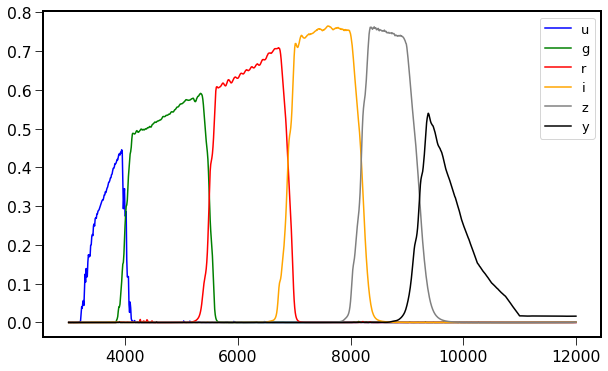

In [53]:
for bp in all_bp:
    plt.plot(bp.wave,bp.throughput,"-",color=filtercolor[band_to_number_2[bp.name]],label=bp.name)
plt.legend()    

## choose an atmosphere

use:
- airmass z=1
- pwv = 4 mm
- ozone = 300 DU
- no cloud


In [54]:
file_atm="libradtran_out/RT_MPL_pp_us_sa_rtvis_z10_wv40_oz30_cld0000.OUT"

In [55]:
arr=np.loadtxt(file_atm)

In [56]:
wl_atm=arr[:,0]
trans_atm=arr[:,1]

In [57]:
bp_atm=S.ArrayBandpass(wl_atm*10., trans_atm, name="atm, airmass 1.0")

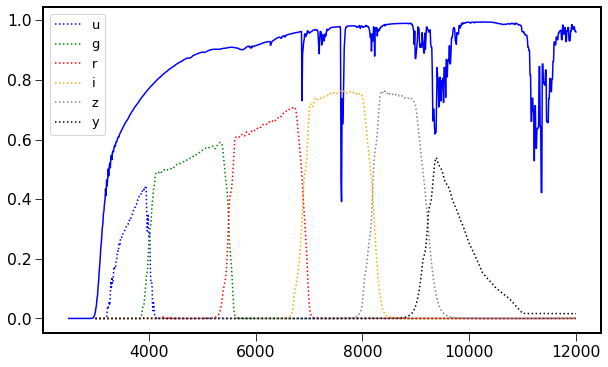

In [58]:
plt.plot(bp_atm.wave,bp_atm.throughput,"b-")
for bp in all_bp:
    plt.plot(bp.wave,bp.throughput,":",color=filtercolor[band_to_number_2[bp.name]],label=bp.name)
plt.legend()  

## Create combined passband : atmosphere x effective filter

In [59]:
all_bp_atm=[]

for bp in all_bp:
    bp_new=bp*bp_atm
    all_bp_atm.append(bp_new)

(0.0, 1.1)

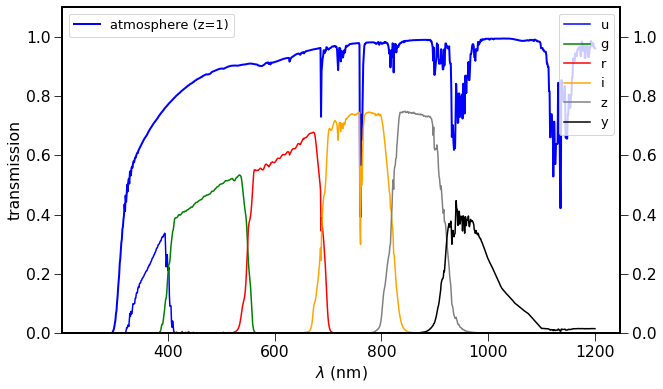

In [60]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)

ax.plot(bp_atm.wave/10,bp_atm.throughput,"b-",lw=2,label="atmosphere (z=1)")
ax.set_ylim(0,1.1)
ax.legend(loc="upper left")
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")

ax2=ax.twinx()

idx=0
for bp in all_bp_atm:
    ax2.plot(bp.wave/10,bp.throughput,"-",color=filtercolor[idx],label=number_to_band_2[idx])
    idx+=1
ax2.legend()    
ax2.set_ylim(0,1.1)



# Observation of Vega

In [61]:
spec_vega.convert("photlam")

## Original SED compared to effective filter

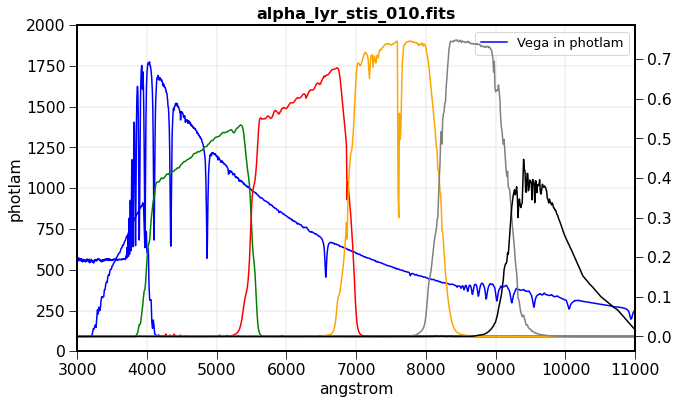

In [62]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)

ax.plot(spec_vega.wave, spec_vega.flux,"b-",label="Vega in photlam")
ax.set_xlabel(spec_vega.waveunits)
ax.set_ylabel(spec_vega.fluxunits)
ax.set_title(os.path.basename(spec_vega.name))
ax.set_xlim(XMIN,XMAX)
ax.set_ylim(0,2000)
ax.grid()
ax.legend()

ax2=ax.twinx()
idx=0
for bp in all_bp_atm:
    ax2.plot(bp.wave,bp.throughput,"-",color=filtercolor[idx],label=bp.name)
    idx+=1
#ax2.legend() 

In [63]:
all_obs=[]
for bp in all_bp_atm:
    obs = S.Observation(spec_vega, bp)
    all_obs.append(obs)

((u * atm, airmass 1.0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * atm, airmass 1.0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * atm, airmass 1.0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * atm, airmass 1.0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * atm, airmass 1.0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * atm, airmass 1.0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


## Number of photoelectrons per second in filters

In [64]:
for obs in all_obs:
    print("observation {} : {:2.3e} ".format(obs.name,obs.countrate()))

observation /Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pysynphot/data/generic/alpha_lyr_stis_010.fits * (u * atm, airmass 1.0) : 5.113e+10 
observation /Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pysynphot/data/generic/alpha_lyr_stis_010.fits * (g * atm, airmass 1.0) : 2.861e+11 
observation /Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pysynphot/data/generic/alpha_lyr_stis_010.fits * (r * atm, airmass 1.0) : 2.156e+11 
observation /Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pysynphot/data/generic/alpha_lyr_stis_010.fits * (i * atm, airmass 1.0) : 1.582e+11 
observation /Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pysynphot/data/generic/alpha_lyr_stis_010.fits * (z * atm, airmass 1.0) : 9.684e+10 
observation /Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pysynphot/data/generic/alpha_lyr_stis_010.fits * (y * atm, airmass 1.0) : 5.448e+10 


### Now the question is to undetstand what count means compared to photlam

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 1.0, 'Bad in counts')

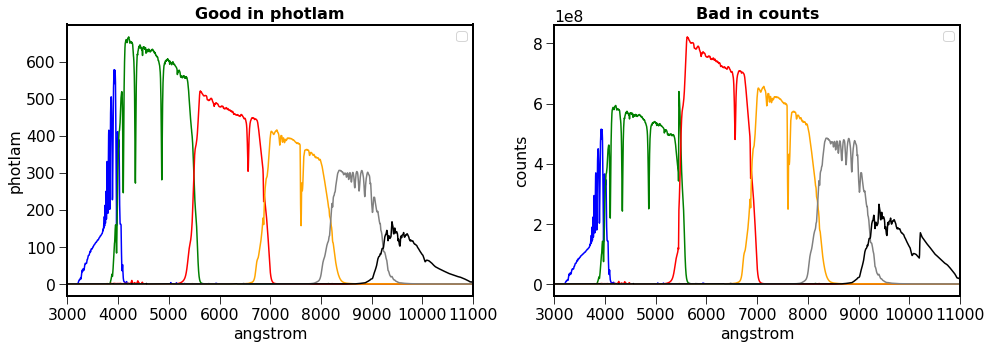

In [74]:
fig=plt.figure(figsize=(16,5))
ax=fig.add_subplot(121)
idx=0

# Obervation converted in photlam
#--------------------------------
for obs in all_obs:
    obs.convert('photlam')
    ax.plot(obs.binwave, obs.binflux,"-",color=filtercolor[idx])

    idx+=1
ax.legend()   
ax.set_ylabel(obs.fluxunits)
ax.set_xlabel(obs.waveunits)
ax.set_xlim(XMIN,XMAX)
ax.set_title("Good in photlam")


ax=fig.add_subplot(122)
idx=0
# Observation converted in count
#--------------------------------
# probably count is done according an internal binning
# then it means nothing
# should not be used for plotting
for obs in all_obs:
    obs.convert('counts')
    ax.plot(obs.binwave, obs.binflux,"-",color=filtercolor[idx])

    idx+=1
ax.legend()   
ax.set_ylabel(obs.fluxunits)
ax.set_xlabel(obs.waveunits)
ax.set_xlim(XMIN,XMAX)
ax.set_title("Bad in counts")


## Take into account the telescope surface and the Exposure

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 1.0, 'Bad in counts x Exposure')

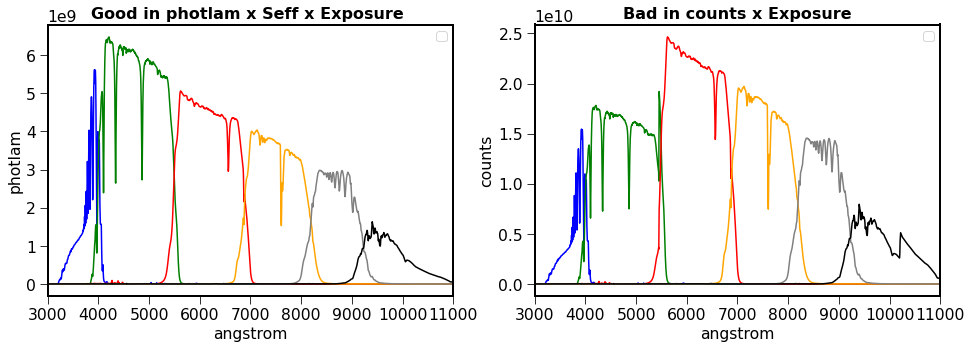

In [66]:
fig=plt.figure(figsize=(16,5))
ax=fig.add_subplot(121)
idx=0

# Obervation converted in photlam
#--------------------------------
for obs in all_obs:
    obs.convert('photlam')
    ax.plot(obs.binwave, obs.binflux*Seff*EXPOSURE,"-",color=filtercolor[idx])

    idx+=1
ax.legend()   
ax.set_ylabel(obs.fluxunits)
ax.set_xlabel(obs.waveunits)
ax.set_xlim(XMIN,XMAX)
ax.set_title("Good in photlam x Seff x Exposure ")

# Observation converted in count
#--------------------------------
# probably count is done according an internal binning
# then it means nothing
# should not be used for plotting
ax=fig.add_subplot(122)
idx=0
for obs in all_obs:
    obs.convert('counts')
    ax.plot(obs.binwave, obs.binflux*EXPOSURE,"-",color=filtercolor[idx])

    idx+=1
ax.legend()   
ax.set_ylabel(obs.fluxunits)
ax.set_xlabel(obs.waveunits)
ax.set_xlim(XMIN,XMAX)
ax.set_title("Bad in counts x Exposure")


# Renormalize Vega at 24 mag

- purpose : check the renormalisation works well.

In [77]:
factor_attenuation = np.power(10,-0.4*24)
factor_attenuation

2.5118864315095717e-10

In [67]:
sp_norm = spec_vega.renorm(24, 'abmag', S.ObsBandpass('johnson,v'))

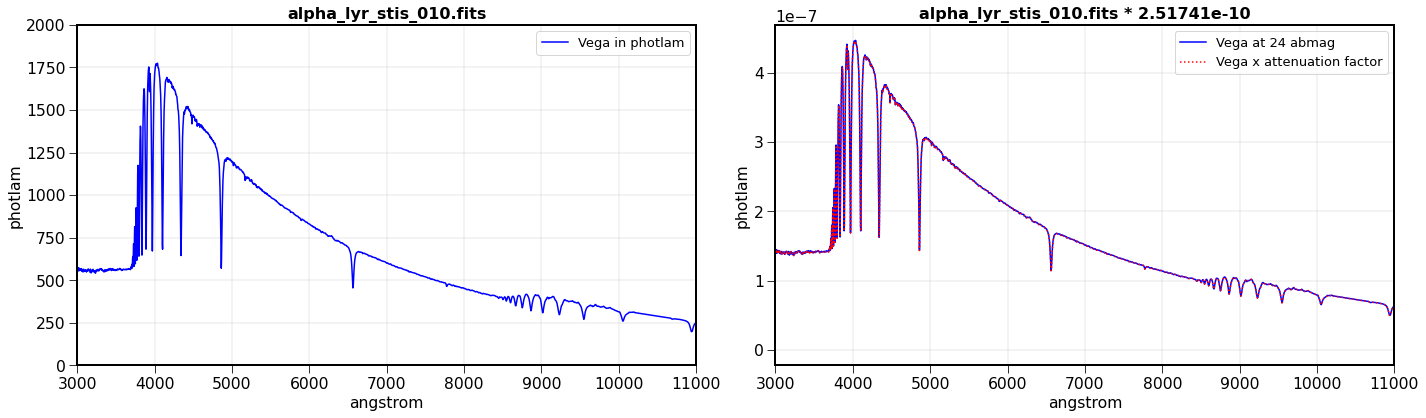

In [79]:
fig=plt.figure(figsize=(20,6))

ax=fig.add_subplot(121)

ax.plot(spec_vega.wave, spec_vega.flux,"b-",label="Vega in photlam")
ax.set_xlabel(spec_vega.waveunits)
ax.set_ylabel(spec_vega.fluxunits)
ax.set_title(os.path.basename(spec_vega.name))
ax.set_xlim(XMIN,XMAX)
ax.set_ylim(0,2000)
ax.grid()
ax.legend()


ax=fig.add_subplot(122)

ax.plot(sp_norm.wave, sp_norm.flux,"b-",label="Vega at 24 abmag")
ax.plot(spec_vega.wave, spec_vega.flux*factor_attenuation,"r:",label="Vega x attenuation factor")
ax.set_xlabel(sp_norm.waveunits)
ax.set_ylabel(sp_norm.fluxunits)
ax.set_title(os.path.basename(sp_norm.name))
ax.set_xlim(XMIN,XMAX)
ax.grid()
ax.legend()

plt.tight_layout()

## Apply renormalissation to observation in LSST

In [69]:
all_obs_renorm=[]
for bp in all_bp_atm:
    obs = S.Observation(sp_norm, bp)
    all_obs_renorm.append(obs)

((u * atm, airmass 1.0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * atm, airmass 1.0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * atm, airmass 1.0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * atm, airmass 1.0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * atm, airmass 1.0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * atm, airmass 1.0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


## Order of magnitudes of photons rate in LSST filters for a 24 mag-star (Vega-like)  

In [70]:
for obs in all_obs_renorm:
    print("observation {} : {:2.3e} ".format(obs.name,obs.countrate()))

observation /Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pysynphot/data/generic/alpha_lyr_stis_010.fits * 2.51741e-10 * (u * atm, airmass 1.0) : 1.287e+01 
observation /Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pysynphot/data/generic/alpha_lyr_stis_010.fits * 2.51741e-10 * (g * atm, airmass 1.0) : 7.203e+01 
observation /Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pysynphot/data/generic/alpha_lyr_stis_010.fits * 2.51741e-10 * (r * atm, airmass 1.0) : 5.428e+01 
observation /Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pysynphot/data/generic/alpha_lyr_stis_010.fits * 2.51741e-10 * (i * atm, airmass 1.0) : 3.983e+01 
observation /Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pysynphot/data/generic/alpha_lyr_stis_010.fits * 2.51741e-10 * (z * atm, airmass 1.0) : 2.438e+01 
observation /Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pysynphot/data/generic/alpha_lyr_stis_010.fits * 2.51741e-10 * (y * atm, airmass 1.0) : 1.372e+01

## Same thing but in photlam

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 1.0, 'Bad in counts')

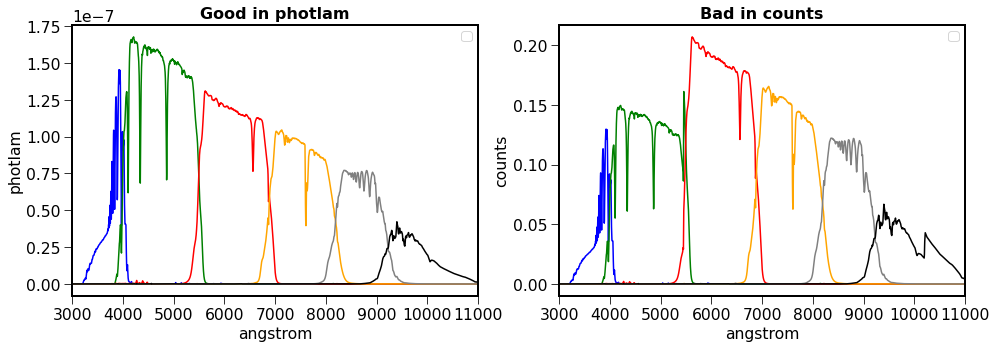

In [71]:
fig=plt.figure(figsize=(16,5))
ax=fig.add_subplot(121)
idx=0
for obs in all_obs_renorm:
    obs.convert('photlam')
    ax.plot(obs.binwave, obs.binflux,"-",color=filtercolor[idx])

    idx+=1
ax.legend()   
ax.set_ylabel(obs.fluxunits)
ax.set_xlabel(obs.waveunits)
ax.set_xlim(XMIN,XMAX)
ax.set_title("Good in photlam")


ax=fig.add_subplot(122)
idx=0
for obs in all_obs_renorm:
    obs.convert('counts')
    ax.plot(obs.binwave, obs.binflux,"-",color=filtercolor[idx])

    idx+=1
ax.legend()   
ax.set_ylabel(obs.fluxunits)
ax.set_xlabel(obs.waveunits)
ax.set_xlim(XMIN,XMAX)
ax.set_title("Bad in counts")


In [84]:
for obs in all_obs_renorm:
    obs.convert('photlam')
    print(obs.binflux.sum()*Seff*EXPOSURE)

140.38596937122242
773.7821891331546
338.49073714841904
244.53653110037965
149.32330084621367
69.31739595768559


In [86]:
for obs in all_obs_renorm:
    obs.convert('count')
    print(obs.binflux.sum()*EXPOSURE)

386.1396118793942
2160.85544369971
1628.4803064692592
1194.7509700607527
731.3656358121997
411.4600834949113
